Now we run this a second time, on the second (`b`) feature table that has removed all epithets with fewer than 27 representative documents. The results are better (overall F1 score for decision tree is `0.44`, random forest is `0.47`; in `a` these were `0.33` and `0.40`, respectively).

In [1]:
import os
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

/root/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn import clone
from sklearn import preprocessing
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

import datetime as dt

In [3]:
fp_df = os.path.expanduser('~/cltk_data/user_data/tlg_bow_df.pickle')
dataframe_bow = joblib.load(fp_df)

In [4]:
Y = dataframe_bow['epithet']

In [5]:
X = dataframe_bow.drop(['epithet', 'id', 'author'], 1)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

In [7]:
def scale_data(X_train, X_test, Y_train, Y_test):
    """Take Vectors, 
    """

    '''
    -PREPOCESSING 
    -Here, scaled data has zero mean and unit varience
    -We save the scaler to later use with testing/prediction data
    '''
    print('Scaling data ...')
    t0 = dt.datetime.utcnow()
    scaler = preprocessing.StandardScaler().fit(X_train)
    fp_scaler = os.path.expanduser('~/cltk_data/user_data/tlg_bow_scaler.pickle')
    joblib.dump(scaler, fp_scaler)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print('... finished in {} secs.'.format(dt.datetime.utcnow() - t0))
    print()

    return X_train_scaled, X_test_scaled, Y_train, Y_test

In [8]:
X_train_scaled, X_test_scaled, Y_train, Y_test = scale_data(X_train, X_test, Y_train, Y_test)

Scaling data ...
... finished in 0:00:02.469028 secs.



# Decision tree

In [12]:
def run_tree(X_train_scaled, X_test_scaled, Y_train, Y_test):
    """Run decision tree with scikit.
    
    Experiment with: 'max_depth'
    """
    '''
    -This is where we define the models with pre-defined parameters
    -We can learn these parameters given our data
    '''
    print('Defining and fitting models ...')
    t0 = dt.datetime.utcnow()
    dec_tree = DecisionTreeClassifier()

    dec_tree.fit(X_train_scaled, Y_train)

    fp_model_pickle = os.path.expanduser('~/cltk_data/user_data/tlg_bow_dt.pickle')
    joblib.dump(dec_tree, fp_model_pickle)

    print('... finished in {} secs.'.format(dt.datetime.utcnow() - t0))
    print()
    

    Y_prediction_tree = dec_tree.predict(X_test_scaled)
    print('tree_predictions ', Y_prediction_tree)

    expected = Y_test
    print('actual_values   ', expected)


    print()
    print('----Tree_report--------------------------------')
    print(classification_report(expected, Y_prediction_tree))
    
    return dec_tree

In [13]:
clf_dec_tree = run_tree(X_train_scaled, X_test_scaled, Y_train, Y_test)

Defining and fitting models ...
... finished in 0:00:10.446019 secs.

tree_predictions  ['Grammatici' 'Scriptores Ecclesiastici' 'Comici' 'Philosophici/-ae'
 'Comici' 'Theologici' 'Philosophici/-ae' 'Tragici' 'Lyrici/-ae'
 'Scriptores Ecclesiastici' 'Historici/-ae' 'Historici/-ae'
 'Philosophici/-ae' 'Philosophici/-ae' 'Comici' 'Historici/-ae' 'Medici'
 'Tragici' 'Tragici' 'Scriptores Ecclesiastici' 'Philosophici/-ae'
 'Tragici' 'Scriptores Ecclesiastici' 'Tragici' 'Philosophici/-ae'
 'Tragici' 'Historici/-ae' 'Philosophici/-ae' 'Tragici' 'Tragici' 'Comici'
 'Historici/-ae' 'Scriptores Ecclesiastici' 'Comici'
 'Scriptores Ecclesiastici' 'Historici/-ae' 'Historici/-ae' 'Historici/-ae'
 'Grammatici' 'Historici/-ae' 'Comici' 'Philosophici/-ae' 'Tragici'
 'Poetae' 'Philosophici/-ae' 'Tragici' 'Historici/-ae' 'Historici/-ae'
 'Historici/-ae' 'Grammatici' 'Lyrici/-ae' 'Philosophici/-ae'
 'Philosophici/-ae' 'Historici/-ae' 'Historici/-ae' 'Historici/-ae'
 'Philosophici/-ae' 'Philosophici/-ae'

In [39]:
from sklearn.tree import export_graphviz  # also `apt-get install graphviz` | also? `pip install graphviz`
from sklearn.externals.six import StringIO  
import pydotplus # pydot is not py3 compatible

In [80]:
# write dot file
dot_tree = os.path.expanduser('~/cltk_data/user_data/decision_tree_depth5.dot')
export_graphviz(clf_dec_tree, out_file=dot_tree, max_depth=5, feature_names=list(dataframe_bow.keys()))

In [81]:
graph = pydotplus.graph_from_dot_file(dot_tree)

In [82]:
dot_tree_svg = os.path.expanduser('~/cltk_data/user_data/decision_tree_depth5.svg')
graph.write_svg(dot_tree_svg)

# also png  -- this was breaking for full tree
# dot_tree_png = os.path.expanduser('~/cltk_data/user_data/decision_tree.png')
# graph.write_svg(dot_tree_png)

True

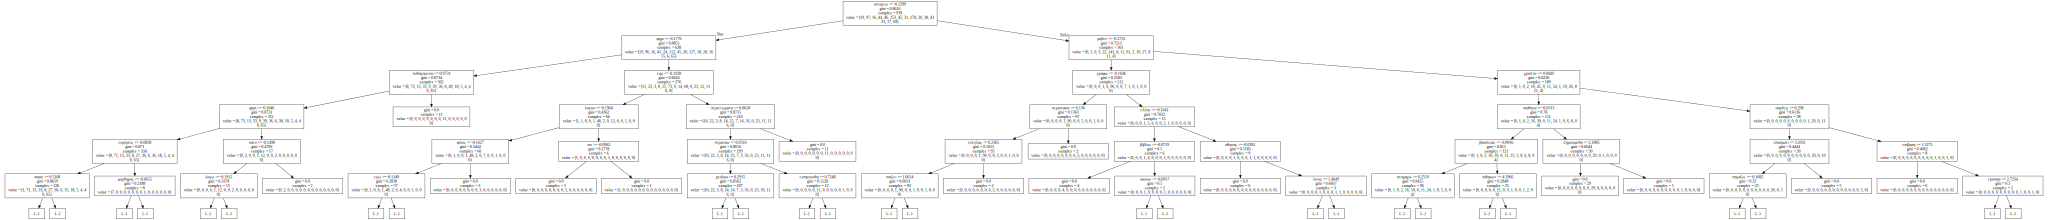

In [83]:
from IPython.display import SVG, display, Image
display(SVG(filename=dot_tree_svg))

# Random forest

In [86]:
def run_random_forest(X_train_scaled, X_test_scaled, Y_train, Y_test):
    """Scikit random forest
    
    Experiment with 'n_estimators'
    """
    t0 = dt.datetime.utcnow()

    n_estimators = 30
    
    rf_model = RandomForestClassifier(n_estimators=n_estimators)

    # Train
    clf = clone(rf_model)
    clf = rf_model.fit(X_train_scaled, Y_train)
    
    #joblib.dump(clf, 'models/random_forest.pickle')

    fp_model_pickle = os.path.expanduser('~/cltk_data/user_data/tlg_bow_fandom_forest.pickle')
    joblib.dump(clf, fp_model_pickle)
    
    scores = clf.score(X_train_scaled, Y_train)
    
    print('... finished in {} secs.'.format(dt.datetime.utcnow() - t0))
    print()
    
    Y_prediction = clf.predict(X_test_scaled)
    print('tree_predictions ', Y_prediction)

    expected = Y_test
    print('actual_values   ', expected)


    print()
    print('----Random forest report--------------------------------')
    print(classification_report(expected, Y_prediction))
    
    return clf

In [87]:
clf_random_forest = run_random_forest(X_train_scaled, X_test_scaled, Y_train, Y_test)

... finished in 0:00:04.907945 secs.

tree_predictions  ['Philosophici/-ae' 'Historici/-ae' 'Comici' 'Philosophici/-ae' 'Comici'
 'Historici/-ae' 'Philosophici/-ae' 'Lyrici/-ae' 'Comici'
 'Scriptores Ecclesiastici' 'Historici/-ae' 'Historici/-ae'
 'Philosophici/-ae' 'Comici' 'Historici/-ae' 'Historici/-ae' 'Comici'
 'Tragici' 'Tragici' 'Scriptores Ecclesiastici' 'Philosophici/-ae'
 'Tragici' 'Scriptores Ecclesiastici' 'Tragici' 'Philosophici/-ae'
 'Tragici' 'Comici' 'Philosophici/-ae' 'Tragici' 'Tragici' 'Historici/-ae'
 'Historici/-ae' 'Scriptores Ecclesiastici' 'Philosophici/-ae'
 'Historici/-ae' 'Historici/-ae' 'Historici/-ae' 'Historici/-ae'
 'Grammatici' 'Historici/-ae' 'Comici' 'Historici/-ae' 'Tragici'
 'Historici/-ae' 'Historici/-ae' 'Tragici' 'Historici/-ae'
 'Philosophici/-ae' 'Historici/-ae' 'Scriptores Ecclesiastici' 'Comici'
 'Philosophici/-ae' 'Philosophici/-ae' 'Historici/-ae' 'Historici/-ae'
 'Philosophici/-ae' 'Historici/-ae' 'Historici/-ae' 'Philosophici/-ae'
 'Epici/

/root/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# ADA boost

In [90]:
def run_ada_boost(X_train_scaled, X_test_scaled, Y_train, Y_test):
    """Scikit random forest.
    
    For plotting see:
    http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html
    
    Experiment with 'n_estimators'
    """
    
    t0 = dt.datetime.utcnow()
    
    n_estimators = 30
    ada_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                                        n_estimators=n_estimators)

    # Train
    clf = clone(ada_classifier)
    clf = ada_classifier.fit(X_train_scaled, Y_train)
    
    fp_model_pickle = os.path.expanduser('~/cltk_data/user_data/tlg_bow_ada_boost.pickle')
    joblib.dump(clf, fp_model_pickle)
    
    scores = clf.score(X_train_scaled, Y_train)
    
    
    
    Y_prediction = clf.predict(X_test_scaled)
    print('tree_predictions ', Y_prediction)

    expected = Y_test
    print('actual_values   ', expected)


    print()
    print(classification_report(expected, Y_prediction))

    print('... finished in {} secs.'.format(dt.datetime.utcnow() - t0))
    print()

In [91]:
run_ada_boost(X_train_scaled, X_test_scaled, Y_train, Y_test)

tree_predictions  ['Comici' 'Historici/-ae' 'Comici' 'Philosophici/-ae' 'Comici'
 'Historici/-ae' 'Philosophici/-ae' 'Comici' 'Philosophici/-ae'
 'Scriptores Ecclesiastici' 'Historici/-ae' 'Historici/-ae' 'Comici'
 'Philosophici/-ae' 'Comici' 'Historici/-ae' 'Comici' 'Comici' 'Comici'
 'Scriptores Ecclesiastici' 'Philosophici/-ae' 'Comici'
 'Scriptores Ecclesiastici' 'Comici' 'Philosophici/-ae' 'Comici'
 'Historici/-ae' 'Alchemistae' 'Comici' 'Comici' 'Comici' 'Historici/-ae'
 'Scriptores Ecclesiastici' 'Historici/-ae' 'Historici/-ae' 'Historici/-ae'
 'Historici/-ae' 'Philosophici/-ae' 'Philosophici/-ae' 'Sophistae' 'Comici'
 'Philosophici/-ae' 'Comici' 'Philosophici/-ae' 'Philosophici/-ae' 'Comici'
 'Philosophici/-ae' 'Philosophici/-ae' 'Historici/-ae'
 'Scriptores Ecclesiastici' 'Comici' 'Sophistae' 'Philosophici/-ae'
 'Philosophici/-ae' 'Philosophici/-ae' 'Philosophici/-ae'
 'Philosophici/-ae' 'Philosophici/-ae' 'Theologici' 'Epici/-ae'
 'Philosophici/-ae' 'Philosophici/-ae' 'Philos

/root/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# SVC

In [93]:
def run_svc(X_train_scaled, X_test_scaled, Y_train, Y_test):
    """Run SVC with scikit."""
    # This is where we define the models with pre-defined parameters
    # We can learn these parameters given our data
    print('Defining and fitting SVC model ...')
    t0 = dt.datetime.utcnow()   
    scv = svm.LinearSVC(C=100.)

    scv.fit(X_train_scaled, Y_train)

    fp_model_pickle = os.path.expanduser('~/cltk_data/user_data/tlg_bow_svc.pickle')
    joblib.dump(scv, fp_model_pickle)
    

    Y_prediction_svc = scv.predict(X_test_scaled)
    print('svc_predictions ', Y_prediction_svc)

    expected = Y_test
    print('actual_values   ', expected)


    print()
    print('----SVC_report--------------------------------')
    print(classification_report(expected, Y_prediction_svc))

    print('... finished in {} secs.'.format(dt.datetime.utcnow() - t0))
    print()

In [ ]:
run_svc(X_train_scaled, X_test_scaled, Y_train, Y_test)

Defining and fitting SVC model ...
